# READ DATA

In [ ]:
import scipy.io
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mat_EEGFeatures = scipy.io.loadmat('/content/drive/MyDrive/ASCERTAIN_Features/Dt_EEGFeatures.mat')
mat_Order_Movie = scipy.io.loadmat('/content/drive/MyDrive/ASCERTAIN_Features/Dt_Order_Movie.mat')
mat_Personality = scipy.io.loadmat('/content/drive/MyDrive/ASCERTAIN_Features/Dt_Personality.mat')
mat_SelfReports = scipy.io.loadmat('/content/drive/MyDrive/ASCERTAIN_Features/Dt_SelfReports.mat')

## .mat to pandas

In [ ]:
import pandas as pd

In [ ]:
pandas_eeg_features = pd.DataFrame(mat_EEGFeatures['EEGFeatures_58'].T)
pandas_order_movie = pd.DataFrame(mat_Order_Movie['PermutationList'])
pandas_personality = pd.DataFrame(mat_Personality['Personality'])

# CLEANING DATA

In [ ]:
import numpy as np

pandas_new_eeg_features

In [ ]:
temp_eeg_features = np.zeros((58, 36*88))
for person in range(58):
    for field in range(36*88):
        if -1000000 < pandas_eeg_features[0][person][int(field / 88)][field % 88] < 1000000 :
            temp_eeg_features[person][field] = pandas_eeg_features[0][person][int(field / 88)][field % 88]
        elif 1000000 < pandas_eeg_features[0][person][int(field / 88)][field % 88]:
            temp_eeg_features[person][field] = 1000000
        elif -1000000 > pandas_eeg_features[0][person][int(field / 88)][field % 88]:
            temp_eeg_features[person][field] = -1000000
        else:
            temp_eeg_features[person][field] = 0
pandas_new_eeg_features = pd.DataFrame(temp_eeg_features)

pandas_self_reports

In [ ]:
temp_self_reports = np.zeros((58, 36*5))
for person in range(58):
  for rating_types in range(5):
    for videos in range(36):
      temp_self_reports[person][rating_types * 36 + videos] = mat_SelfReports['Ratings'][rating_types][person][videos]
pandas_self_reports = pd.DataFrame(temp_self_reports)

## make lable with median

pandas_median_personality

In [ ]:
pandas_median_personality = pandas_personality.median()

pandas_median_lable

In [ ]:
epsilon = 0.000000001
pandas_median_lable = pandas_personality > pandas_median_personality + epsilon


## normalise EEG features

In [ ]:
from sklearn import preprocessing

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(pandas_new_eeg_features)
pandas_normalize_eeg_features = pd.DataFrame(x_scaled)

# PREDICTION

In [ ]:
index_to_personality_traits ={
    0 : "Extraversion",
    1 : "Agreeableness",
    2 : "Conscientiousness",
    3 : "Emotional Stability",
    4 : "Openness"
}

In [ ]:
results = pd.DataFrame(data=[[.0 for i in range(8)] for j in range(5)],columns=[
                                'svm_linear',
                                'svm_rbf',
                                'naive_bayes_gaussian',
                                'naive_bayes_multinomial',
                                'random_forest',
                                'neural_network',
                                'logistic_regression',
                                'k_neighbors'])

In [ ]:
index_to_tab = {
    0 : "\t",
    1 : "\t",
    2 : "",
    3 : "",
    4 : "\t"
}

## Support vector machine

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import svm

linear svm

In [ ]:
svc = svm.SVC(kernel = 'linear')
print('svm_linear:\n')
for i in range(5):
  score = cross_val_score( svc, pandas_normalize_eeg_features, pandas_median_lable[i], cv = 25)
  results['svm_linear'][i] = score.mean()
  print(index_to_personality_traits[i], index_to_tab[i], '\t:', score.mean())

svm_linear:

Extraversion 	 	: 0.6933333333333332
Agreeableness 	 	: 0.44
Conscientiousness  	: 0.5333333333333333
Emotional Stability  	: 0.5466666666666666
Openness 	 	: 0.48


rbf svm

In [ ]:
svc = svm.SVC(kernel = 'rbf')
print('svm_rbf:\n')
for i in range(5):
  score = cross_val_score( svc, pandas_normalize_eeg_features, pandas_median_lable[i], cv = 25)
  results['svm_rbf'][i] = score.mean()
  print(index_to_personality_traits[i], index_to_tab[i], '\t:', score.mean())

svm_rbf:

Extraversion 	 	: 0.66
Agreeableness 	 	: 0.5
Conscientiousness  	: 0.5266666666666666
Emotional Stability  	: 0.5133333333333333
Openness 	 	: 0.5533333333333332


## Naive Bayes

gaussian naive bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
gnb = GaussianNB()
print('naive_bayes_gaussian:\n')
for i in range(5):
  score = cross_val_score( gnb, pandas_normalize_eeg_features, pandas_median_lable[i], cv = 25)
  results['naive_bayes_gaussian'][i] = score.mean()
  print(index_to_personality_traits[i], index_to_tab[i], '\t:', score.mean())

naive_bayes_gaussian:

Extraversion 	 	: 0.58
Agreeableness 	 	: 0.44666666666666666
Conscientiousness  	: 0.4733333333333333
Emotional Stability  	: 0.5
Openness 	 	: 0.48666666666666664


multinomial naive bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
mnb = MultinomialNB(alpha=3)
print('naive_bayes_multinomial:\n')
for i in range(5):
  score = cross_val_score( mnb, pandas_normalize_eeg_features, pandas_median_lable[i], cv = 25)
  results['naive_bayes_multinomial'][i] = score.mean()
  print(index_to_personality_traits[i], index_to_tab[i], '\t:', score.mean())

naive_bayes_multinomial:

Extraversion 	 	: 0.6866666666666665
Agreeableness 	 	: 0.38
Conscientiousness  	: 0.4333333333333333
Emotional Stability  	: 0.5266666666666666
Openness 	 	: 0.5266666666666666


## Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(n_estimators=10000)
print('random_forest:\n')
for i in range(5):
  score = cross_val_score( rfc, pandas_normalize_eeg_features, pandas_median_lable[i], cv = 25)
  results['random_forest'][i] = score.mean()
  print(index_to_personality_traits[i], index_to_tab[i], '\t:', score.mean())

random_forest:

Extraversion 	 	: 0.6466666666666666
Agreeableness 	 	: 0.5333333333333333
Conscientiousness  	: 0.5733333333333333
Emotional Stability  	: 0.46
Openness 	 	: 0.58


## Neural network

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
dp = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(10), random_state=1,max_iter=10000, warm_start=True)
print('neural_network:\n')
for i in range(5):
  score = cross_val_score( dp, pandas_normalize_eeg_features, pandas_median_lable[i], cv = 25)
  results['neural_network'][i] = score.mean()
  print(index_to_personality_traits[i], index_to_tab[i], '\t:', score.mean())

neural_network:

Extraversion 	 	: 0.7133333333333333
Agreeableness 	 	: 0.4
Conscientiousness  	: 0.54
Emotional Stability  	: 0.4666666666666666
Openness 	 	: 0.5533333333333332


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(random_state=0, solver='lbfgs', max_iter=30000)
print('logistic_regression:\n')
for i in range(5):
  score = cross_val_score( lr, pandas_normalize_eeg_features, pandas_median_lable[i], cv = 25)
  results['logistic_regression'][i] = score.mean()
  print(index_to_personality_traits[i], index_to_tab[i], '\t:', score.mean())

logistic_regression:

Extraversion 	 	: 0.6533333333333333
Agreeableness 	 	: 0.44
Conscientiousness  	: 0.5333333333333333
Emotional Stability  	: 0.5466666666666666
Openness 	 	: 0.48


## K neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=19)
print('k_neighbors:\n')
for i in range(5):
  score = cross_val_score( knn, pandas_normalize_eeg_features, pandas_median_lable[i], cv = 25)
  results['k_neighbors'][i] = score.mean()
  print(index_to_personality_traits[i], index_to_tab[i], '\t:', score.mean())

k_neighbors:

Extraversion 	 	: 0.6866666666666665
Agreeableness 	 	: 0.54
Conscientiousness  	: 0.54
Emotional Stability  	: 0.54
Openness 	 	: 0.5333333333333333


# RESULTS

In [ ]:
results_table = results.copy()
results_table.index = results_table.index.map(index_to_personality_traits)

In [ ]:
results_table

,svm_linear,svm_rbf,naive_bayes_gaussian,naive_bayes_multinomial,random_forest,neural_network,logistic_regression,k_neighbors
Extraversion,0.693333,0.660000,0.580000,0.686667,0.646667,0.713333,0.653333,0.686667
Agreeableness,0.440000,0.500000,0.446667,0.380000,0.533333,0.400000,0.440000,0.540000
Conscientiousness,0.533333,0.526667,0.473333,0.433333,0.573333,0.540000,0.533333,0.540000
Emotional Stability,0.546667,0.513333,0.500000,0.526667,0.460000,0.466667,0.546667,0.540000
Openness,0.480000,0.553333,0.486667,0.526667,0.580000,0.553333,0.480000,0.533333


In [ ]:
results_table.transpose()

,Extraversion,Agreeableness,Conscientiousness,Emotional Stability,Openness
svm_linear,0.693333,0.440000,0.533333,0.546667,0.480000
svm_rbf,0.660000,0.500000,0.526667,0.513333,0.553333
naive_bayes_gaussian,0.580000,0.446667,0.473333,0.500000,0.486667
naive_bayes_multinomial,0.686667,0.380000,0.433333,0.526667,0.526667
random_forest,0.646667,0.533333,0.573333,0.460000,0.580000
neural_network,0.713333,0.400000,0.540000,0.466667,0.553333
logistic_regression,0.653333,0.440000,0.533333,0.546667,0.480000
k_neighbors,0.686667,0.540000,0.540000,0.540000,0.533333


# REGRESSION

## make train and test

train

In [ ]:
regr_train_x = pandas_new_eeg_features[0:40][0:88]
regr_train_y = pandas_personality[0:40]

test

In [ ]:
regr_test_x = pandas_new_eeg_features[40:][0:88]
regr_test_y = pandas_personality[40:]

## make extra data for feed

real data

In [ ]:
regr_extra_data_x = regr_train_x.copy()
regr_extra_data_y = regr_train_y.copy()

x out of 36

In [ ]:
from numpy import random

In [ ]:
number_of_samples = 5000
for samples in range(number_of_samples):
  x = random.randint(36)
  num = random.randint(len(regr_train_x))
  lst = list(range(36))
  random.shuffle(lst)

  data_to_append = {}
  for cnt in range(len(regr_train_x.columns)):
    if (cnt % 88) in lst[0:x]:
      data_to_append[regr_train_x.columns[cnt]] = 0
    else:
      data_to_append[regr_train_x.columns[cnt]] = regr_train_x[cnt % 88][num]
  regr_extra_data_x = regr_extra_data_x.append(data_to_append, ignore_index = True)
  regr_extra_data_y = regr_extra_data_y.append(regr_train_y.iloc[[num]], ignore_index = True)

real data copies

In [ ]:
samples = 10
for i in range(samples):
  regr_extra_data_x = regr_extra_data_x.append(regr_train_x, ignore_index = True)
  regr_extra_data_y = regr_extra_data_y.append(regr_train_y, ignore_index = True)

NameError: ignored

## show regr_extra_data_train

In [ ]:
regr_extra_data_x

,0,1,2,3,4,5,6,7,8,9,...,3158,3159,3160,3161,3162,3163,3164,3165,3166,3167
0,320.191443,82.717586,0.622098,8.653932,0.118051,0.103685,-0.035643,0.490625,0.719550,0.277515,...,47.426752,1.067962,4.037701,0.130543,0.153654,-0.034132,0.843750,0.019988,3.744179,0.039975
1,320.654279,43.335374,0.017898,5.028319,0.133666,0.146159,0.010669,0.490000,0.539663,-0.094304,...,28.687590,0.961289,2.504682,0.209869,0.003748,-0.006331,0.639375,0.139913,10.506138,0.159900
2,325.104934,114.114679,1.175495,9.812147,0.088070,0.089944,-0.044397,0.528125,0.679575,0.508821,...,69.561561,0.504377,2.403951,0.199875,0.182386,-0.007994,0.713750,0.079950,0.430625,0.079950
3,317.878201,143.475261,0.716292,5.650146,0.114928,0.128670,-0.054897,0.508125,0.799500,0.607019,...,99.998150,0.764074,2.515714,0.218613,0.154279,-0.080086,0.834375,0.059963,1.871295,0.059963
4,319.445971,50.873505,-1.387409,8.310769,0.078076,0.111805,0.012549,0.505000,0.339788,-0.115373,...,18.070774,0.412422,2.188909,0.197377,0.290443,-0.015312,0.590625,0.019988,17.205056,0.039975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5035,339.759838,0.000000,0.582543,3.830769,0.172392,0.086821,-0.153528,0.542500,0.379763,0.000000,...,41.127319,-2.835412,9.945743,0.000000,0.109307,-0.120000,0.193125,0.000000,3.634794,0.019988
5036,0.000000,176.859114,0.167600,2.785957,0.000000,0.000000,0.000000,0.521250,0.000000,-0.451179,...,219.903697,-0.704062,2.456265,0.000000,0.176765,0.272523,0.463125,0.059963,-0.930374,0.119925
5037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,60.983298,0.271648,2.047882,0.185509,0.170518,-0.013104,0.830625,0.059963,2.904388,0.039975
5038,340.243285,160.628762,0.000000,0.000000,0.126171,0.120550,0.000000,0.501250,0.000000,-3.406307,...,271.237641,1.335981,3.403402,0.160525,0.000000,0.465694,0.461250,0.099938,-10.111673,0.099938


In [ ]:
regr_extra_data_y

,0,1,2,3,4
0,5.4,5.9,5.2,5.1,5.2
1,3.0,5.1,4.3,3.7,4.6
2,3.9,5.4,4.4,4.8,3.9
3,2.9,4.1,5.6,5.7,4.0
4,3.2,4.8,6.1,5.7,4.7
...,...,...,...,...,...
5035,4.1,5.5,3.9,3.8,5.0
5036,5.5,5.3,4.5,3.8,5.7
5037,3.1,3.8,4.7,4.1,4.3
5038,3.1,5.9,4.6,4.4,4.8


## regr_normalized_extra_data_train_x

add test to it

In [ ]:
regr_extra_data_x = regr_extra_data_x.append(regr_test_x, ignore_index = True)
regr_extra_data_y = regr_extra_data_y.append(regr_test_y, ignore_index = True)

normalizing

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(regr_extra_data_x)
regr_normalized_extra_data_x = pd.DataFrame(x_scaled)

## test

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
regr = LinearRegression().fit(regr_normalized_extra_data_x[:-17], regr_extra_data_y[4][:-17])


20_000

In [ ]:
regr.predict(regr_normalized_extra_data_x[-17:])

array([7.09672293, 4.81087537, 4.19516054, 3.33146409, 5.25329006,
       5.64209901, 5.50722805, 4.54535669, 6.67673452, 5.53645332,
       5.97323575, 4.41589998, 6.48644033, 5.39813779, 6.66571248,
       4.18962144, 6.86389916])

10_000

In [ ]:
regr.predict(regr_normalized_extra_data_x[-17:])

array([6.80632228, 5.16620991, 4.99852727, 3.38918713, 5.31628849,
       5.34240788, 5.66332552, 4.93934944, 6.5085644 , 5.50675052,
       5.5997384 , 4.58940204, 6.34485305, 5.40263878, 6.19010714,
       4.24877567, 6.98216216])

1000

In [ ]:
regr.predict(regr_normalized_extra_data_x[-17:])

array([7.09442739, 4.80990492, 4.20366914, 3.33027086, 5.25045776,
       5.63901508, 5.50617702, 4.54954557, 6.68191051, 5.53797613,
       5.96042693, 4.41819013, 6.49417996, 5.3930325 , 6.66354831,
       4.18186351, 6.86991265])

In [ ]:
regr_test_y[4][1:]

41    5.5
42    4.6
43    5.3
44    4.9
45    4.8
46    4.3
47    5.2
48    4.8
49    4.7
50    5.3
51    6.5
52    4.8
53    5.4
54    6.5
55    5.1
56    4.2
57    6.6
Name: 4, dtype: float64

In [ ]:
pandas_median_personality

0    4.45
1    5.10
2    5.20
3    4.20
4    4.90
dtype: float64

In [ ]:
pandas_personality

,0,1,2,3,4
0,5.4,5.9,5.2,5.1,5.2
1,3.0,5.1,4.3,3.7,4.6
2,3.9,5.4,4.4,4.8,3.9
3,2.9,4.1,5.6,5.7,4.0
4,3.2,4.8,6.1,5.7,4.7
5,3.5,4.9,5.4,3.9,4.9
6,5.5,5.4,5.0,4.3,5.4
7,3.1,5.9,4.6,4.4,4.8
8,5.9,4.7,3.9,3.0,4.9
9,4.9,5.6,5.9,4.0,5.4


20_000 0

In [ ]:
regr.predict(regr_normalized_extra_data_x[-17:])

array([ 9.71601097,  6.76668251,  4.74921844,  3.01875391,  9.50702737,
        6.16946379,  6.25542221,  3.22075733,  9.33856194,  7.98305662,
       10.6616835 ,  5.86600926,  9.36729358,  7.39881964, 11.78071359,
        3.90816595, 14.39209246])

20_000 1

In [ ]:
regr.predict(regr_normalized_extra_data_x[-17:])

array([ 9.93021742,  5.76042333,  3.38071217,  1.51532756,  7.42619793,
        6.69848798,  6.00068647,  2.74905689, 10.15824241,  7.7247473 ,
        9.18484816,  4.28273436,  8.31750895,  7.0572977 , 11.11945102,
        3.2311925 , 12.76302072])

20_000 2

In [ ]:
regr.predict(regr_normalized_extra_data_x[-17:])

array([3.1674912 , 4.67055592, 4.10441611, 4.31001528, 6.11851503,
       2.85409861, 3.52300815, 3.19631292, 3.05778249, 4.11833596,
       5.57653557, 5.60876202, 3.84453678, 3.56599709, 5.710785  ,
       4.16013319, 5.75043998])

20_000 3

In [ ]:
regr.predict(regr_normalized_extra_data_x[-17:])

array([3.66108362, 4.22698555, 3.1521584 , 3.5818608 , 4.02540884,
       3.23350272, 3.24883053, 2.38178817, 4.29509927, 4.40119453,
       4.89174229, 4.36057124, 4.19196106, 3.58711096, 5.42395485,
       3.13290049, 6.3232254 ])

20_000 4

In [ ]:
regr.predict(regr_normalized_extra_data_x[-17:])

array([7.09672293, 4.81087537, 4.19516054, 3.33146409, 5.25329006,
       5.64209901, 5.50722805, 4.54535669, 6.67673452, 5.53645332,
       5.97323575, 4.41589998, 6.48644033, 5.39813779, 6.66571248,
       4.18962144, 6.86389916])

5000

5000 0

In [ ]:
regr.predict(regr_normalized_extra_data_x[-17:])

array([ 9.630079  ,  6.76390791,  4.79669445,  3.08842999,  9.51716647,
        6.18680618,  6.16553516,  3.20566455,  9.39522187,  7.85984264,
       10.75606745,  5.83885443,  9.45970484,  7.54638482, 11.56957297,
        3.79580697, 14.23048754])

5000 1

In [ ]:
regr.predict(regr_normalized_extra_data_x[-17:])

array([ 9.92489403,  5.7322397 ,  3.4004827 ,  1.54226635,  7.44036118,
        6.69798373,  5.96540622,  2.7297523 , 10.16953717,  7.69878976,
        9.20024688,  4.28252826,  8.32047374,  7.09920365, 11.08167024,
        3.19905874, 12.73999207])

5000 2

In [ ]:
regr.predict(regr_normalized_extra_data_x[-17:])

array([3.16497312, 4.67917545, 4.10277397, 4.30543712, 6.11428431,
       2.85239544, 3.53002824, 3.20070129, 3.05742243, 4.12154792,
       5.57732923, 5.60916419, 3.84831891, 3.56086751, 5.71436897,
       4.1660405 , 5.75086615])

5000 3

In [ ]:
regr.predict(regr_normalized_extra_data_x[-17:])

array([3.63434912, 4.2319599 , 3.17049328, 3.5992828 , 4.02410402,
       3.22535681, 3.22685789, 2.37257771, 4.31389543, 4.37021899,
       4.92323335, 4.35535102, 4.22436321, 3.62902161, 5.36556673,
       3.10873962, 6.28011617])

5000 4

In [ ]:
regr.predict(regr_normalized_extra_data_x[-17:])

array([7.0321398 , 4.81772847, 4.22930734, 3.37700693, 5.25580482,
       5.64900062, 5.44931498, 4.53629912, 6.71808822, 5.45163548,
       6.04319996, 4.39724822, 6.55803382, 5.50003619, 6.51686978,
       4.11603049, 6.74886731])

500

500 0

In [ ]:
regr.predict(regr_normalized_extra_data_x[-17:])

array([ 9.72663484,  6.74456392,  4.7535253 ,  3.02702588,  9.51557192,
        6.16423568,  6.24084041,  3.20343838,  9.33944324,  7.98263898,
       10.65785563,  5.86711815,  9.35576247,  7.40621338, 11.78011165,
        3.9010944 , 14.40189517])

500 1

In [ ]:
regr.predict(regr_normalized_extra_data_x[-17:])

array([ 9.94861324,  5.72906687,  3.39331751,  1.52298325,  7.44869736,
        6.6881146 ,  5.98013164,  2.72331799, 10.14987482,  7.72213432,
        9.16992277,  4.27987113,  8.29837215,  7.06555686, 11.1218863 ,
        3.22827081, 12.77353533])

500 2

In [ ]:
regr.predict(regr_normalized_extra_data_x[-17:])

array([3.16302292, 4.67920671, 4.10212126, 4.30716236, 6.11419781,
       2.8564215 , 3.52870023, 3.20319796, 3.05834094, 4.11868909,
       5.57892473, 5.60874484, 3.84930869, 3.56331405, 5.71071159,
       4.16223186, 5.74692368])

500 3

In [ ]:
regr.predict(regr_normalized_extra_data_x[-17:])

array([3.6644729 , 4.22459426, 3.15699122, 3.58001972, 4.03331118,
       3.23094749, 3.24733273, 2.37911846, 4.28873286, 4.39979151,
       4.88494615, 4.35771105, 4.18884   , 3.58641695, 5.42609942,
       3.13690872, 6.32201266])

500 4

In [ ]:
regr.predict(regr_normalized_extra_data_x[-17:])

array([7.10101673, 4.80310495, 4.19776806, 3.33368456, 5.25804076,
       5.6397636 , 5.50212507, 4.5390726 , 6.67542472, 5.5359663 ,
       5.97029148, 4.41554269, 6.48191961, 5.400361  , 6.66605479,
       4.18833328, 6.86677339])

In [ ]:
pandas_median_lable

,0,1,2,3,4
0,True,True,False,True,True
1,False,False,False,False,False
2,False,True,False,True,False
3,False,False,True,True,False
4,False,False,True,True,False
5,False,False,True,False,False
6,True,True,False,True,True
7,False,True,False,True,False
8,True,False,False,False,False
9,True,True,True,False,True


In [ ]:
regr = linear_model.LinearRegression()
print('mulit_linear_regression:\n')
for i in range(5):
  score = cross_val_score( regr, pandas_normalize_eeg_features, pandas_personality[i], cv = 25)
  print(index_to_personality_traits[i], index_to_tab[i], '\t:', score.mean())

mulit_linear_regression:

Extraversion 	 	: -4.917463002760152
Agreeableness 	 	: -11.531186752370159
Conscientiousness  	: -2.5042592024642256
Emotional Stability  	: -5.393546208021621
Openness 	 	: -12.149484112768121


# temp

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [ ]:
model = Sequential()
model.add(Dense(36,activation='relu',input_shape=(3168,)))
model.add(Dense(36,activation='relu'))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='Adam',loss=tf.keras.losses.MeanSquaredError())

In [ ]:
x_train = regr_normalized_extra_data_x[:-17]
y_train = regr_extra_data_y[4][:-17]
x_test = regr_normalized_extra_data_x[-17:]
y_test = regr_extra_data_y[4][-17:]

In [ ]:
model.fit(x=x_train,y=y_train,
          validation_data=(x_test,y_test),
          batch_size=1,epochs=100)
model.summary()

Epoch 1/100
5041/5041 [==============================] - 7s 1ms/step - loss: 0.2455 - val_loss: 0.6718
Epoch 2/100
5041/5041 [==============================] - 8s 1ms/step - loss: 0.1272 - val_loss: 1.1049
Epoch 3/100
5041/5041 [==============================] - 6s 1ms/step - loss: 0.0834 - val_loss: 0.6088
Epoch 4/100
5041/5041 [==============================] - 6s 1ms/step - loss: 0.0602 - val_loss: 0.6522
Epoch 5/100
5041/5041 [==============================] - 6s 1ms/step - loss: 0.0481 - val_loss: 0.8381
Epoch 6/100
5041/5041 [==============================] - 6s 1ms/step - loss: 0.0416 - val_loss: 0.8322
Epoch 7/100
5041/5041 [==============================] - 6s 1ms/step - loss: 0.0322 - val_loss: 0.9978
Epoch 8/100
5041/5041 [==============================] - 7s 1ms/step - loss: 0.0326 - val_loss: 0.8056
Epoch 9/100
5041/5041 [==============================] - 6s 1ms/step - loss: 0.0250 - val_loss: 0.9726
Epoch 10/100
5041/5041 [==============================] - 6s 1ms/step - l

In [ ]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 17ms/step - loss: 1.0408


1.0408450365066528

In [ ]:
model.predict(x_test)

array([[4.858167 ],
       [4.178873 ],
       [4.733989 ],
       [4.7954326],
       [4.856232 ],
       [5.013078 ],
       [5.0597897],
       [4.430618 ],
       [4.6388206],
       [4.6285725],
       [4.4306374],
       [4.7832994],
       [5.1536436],
       [4.5187564],
       [4.388255 ],
       [4.662722 ],
       [4.0188737]], dtype=float32)

In [ ]:
import matplotlib.pyplot as plt

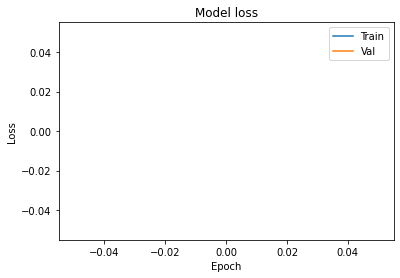

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()